# Echo State Stochastic Volatility Heston Dynamical Model

# The Modeling Perspective

This data is from SPX&500. Here, we're interested in modeling the stock price rather than modeling the option price, as of calculating option requires us model the stock price first. We know about the stock price follows the Heston Model:

\begin{aligned}
dS_t &= \mu S_t dt + \sqrt{v_t}S_td\tilde W_t \\
dv_t &= k(\mu - v_t)dt + \alpha \sqrt{v_t}d\tilde W_t'\\
\rho dt &= \mathbb{E}(d\tilde W_t+d\tilde W_t')
\end{aligned}

This does have a close solution by geometrical transformation. However, here we're using the Echo State Neural Network to model the volatility process $v_t$. Therefore, the heston model becomes:

\begin{aligned}
dS_t &= \mu S_t dt + \sqrt{v_t}S_td\tilde W_t \\
v_t &= \text{ESN}_t(\mathbf{u}(t), \mathbf{x}(t)) \\
\mathbf{u}(t) &= \text{return}(:t-1) \\
\mathbf{x}(t) &= \sigma_{\text{tanh}} ( \mathbf{W}_{\text{in}}\mathbf{u}(t) + \mathbf{W}_{\text{r}}(\mathbf{x}(t-1) + \epsilon) )
\end{aligned}

We might first model the constant drift geometric brownian motion process. Then, we can build another parallel ESN for forcasting the stochastic drift process, namely: 

\begin{aligned}
dS_t &= \mu_t S_t dt + \sqrt{v_t}S_td\tilde W_t \\
v_t &= \text{ESN}^1_t(\mathbf{u}(t), \mathbf{x}(t)) \\
\mu_t &= \text{ESN}^2_t(\mathbf{u}(t), \mathbf{x}(t))\\
\mathbf{u}(t) &= \text{return}(:t-1) \\
\mathbf{x}(t) &= \sigma_{\text{tanh}} ( \mathbf{W}_{\text{in}}\mathbf{u}(t) + \mathbf{W}_{\text{r}}(\mathbf{x}(t-1) + \epsilon) )
\end{aligned}



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns
import math
import os
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split


In [80]:
def EchoStateDeepTest(x_dim, connectivity, spectral_radius,
                  u_num, u_dim, u_mag,
                  leak, cutout, forget, 
                  cv_start, cv_end, cv_step, val_cut, verbose, input_U, target_Y, resvoir_num):
    if verbose:
        print()
        print("-----------------------------------------------Making Transition and input matrix------------------------------------------------")
        print()

    # Making inner transition sparse matrix W
    W_list = []
    for i in range(resvoir_num):
        nans = np.random.randint(0, int(1/connectivity)-1 , size=(x_dim, x_dim))
        W = np.random.uniform(-0.4, 0.4, x_dim*x_dim).reshape([x_dim, x_dim])
        W = np.where(nans, np.nan, W)
        W = np.nan_to_num(W)
        E, _ = np.linalg.eig(W)
        e_max = np.max(np.abs(E))
        W /= np.abs(e_max)/spectral_radius   
        W_list.append(W)
        
    #
    W_trans_list = []
    for i in range(resvoir_num-1):
        W_trans = np.random.uniform(-1, 1, x_dim*x_dim).reshape([x_dim, x_dim])
        W_trans_list.append(W_trans) 
        
        
    # Making input matrix W_in
    W_in = np.random.uniform(-1, 1, x_dim*u_dim).reshape([x_dim, u_dim])
    W_in = W_in / (np.linalg.svd(W_in)[1].tolist()[0]*1.2)

    if verbose:
        print("Shape of W: ", str(W.shape))
        print("Shape of W_in:", str(W_in.shape))

        print()
        print("-----------------------------------------------Making input and inner states------------------------------------------------------")
        print()

        
        
        
    # Making Inner States
    X = u
       
    x_lists = []
    x_list = [np.zeros([x_dim]), np.zeros([x_dim])]

    # 1st reservoir
    for i in range(u_num):
        x_next = (1-leak)*x_list[-2] + leak * np.tanh( np.matmul(W_in, u[i]) + np.matmul(W_list[0], x_list[-1] ) +  np.random.rand(x_dim))
        x_list.append(x_next)
    x_lists.append(x_list)
    
    # 2-last reservoirs
    for res in range(resvoir_num-1):
        x_list = [np.zeros([x_dim]), np.zeros([x_dim])]
        for i in range(u_num):
            x_next = (1-leak)*x_list[-2] + leak * np.tanh( np.matmul(W_trans_list[res], x_lists[res][i+2]) + np.matmul(W_list[res], x_list[-1] ) +  np.random.rand(x_dim))
            x_list.append(x_next)
        x_lists.append(x_list)
        
    states = np.array(x_lists[-1][1:]).reshape(u_num+1, x_dim)

    if verbose:
        print("Inner States: # of samples x # of dimension:", str(states.shape))
        print("Input States: # of samples x # of dimension:", str(u.shape))

        print()
        print("------------------------------------------------Concatenate data and Y sequence data------------------------------------------------")
        print()

        # Making Concatenated data

    X = np.concatenate([states[:-1,:], u], axis=1)
    X = X[:-1, :]

    
    
    
    
    # Faking Target sequence
    Y = target_Y


    if verbose:
        print("Inner + Input States: # of samples x # of dimension:", str(X.shape))
        print("Targeted fitting sequence: # of samples x # of dimension:", str(Y.shape))

        print()
        print("--------------------------------------------------Splitting Data to 3-------------------------------------------------------------")
        print()

    # Split into 3 trunks, usless trunk, regressing trunk, predicting trunk
    useless_X = X[:forget, :]
    useless_Y = Y[:forget, :]

    regress_X = X[forget:-cutout, :]
    regress_Y = Y[forget:-cutout, :]
    
    train_size = int(regress_X.shape[0]*(1-val_cut))
    
    train_X = np.split(regress_X, [train_size, regress_X.shape[0]+1])[0]
    train_Y = np.split(regress_Y, [train_size, regress_X.shape[0]+1])[0]
       
    val_X = np.split(regress_X, [train_size, regress_X.shape[0]+1])[1]
    val_Y = np.split(regress_Y, [train_size, regress_X.shape[0]+1])[1]
        
    predict_X = X[-cutout:, :]
    predict_Y = Y[-cutout:, :]

    if verbose:
        print("useless_X: # of samples x # of dimension:", str(useless_X.shape))
        print("useless_Y: # of samples x # of dimension:", str(useless_Y.shape))
        print("regress_X: # of samples x # of dimension:", str(regress_X.shape))
        print("regress_Y: # of samples x # of dimension:", str(regress_Y.shape))
        print("train_X: # of samples x # of dimension:", str(train_X.shape))
        print("train_Y: # of samples x # of dimension:", str(train_Y.shape))
        print("val_X: # of samples x # of dimension:", str(val_X.shape))
        print("val_Y: # of samples x # of dimension:", str(val_Y.shape))
        print("predict_X: # of samples x # of dimension:", str(predict_X.shape))
        print("predict_Y: # of samples x # of dimension:", str(predict_Y.shape))

        print()
        print("---------------------------------------------------Conducting Regression----------------------------------------------------------")
        print()

    alpha = cv_start
    mse = {}
    while alpha <= cv_end:

        # Conducting linear regression
        reg = Ridge(alpha).fit(train_X, train_Y)

        # Making prediction
        valhat_Y = reg.predict(val_X)
        alpha += cv_step

        loss = np.mean(np.multiply(   (val_Y - valhat_Y), (val_Y - valhat_Y)))
        mse[alpha] = loss


    best_mse = min(list(mse.values()))
    best_alpha = list(mse.keys())[list(mse.values()).index(best_mse)]


    # using best regression again
    reg = Ridge(best_alpha).fit(regress_X, regress_Y)

    # Making prediction
    predhat_Y = reg.predict(predict_X)
    
    # showing training error, 
    regrpred_Y = reg.predict(regress_X)
    train_mse = np.mean(np.multiply(   (regrpred_Y - regress_Y), (regrpred_Y - regress_Y)))
    pred_mse = np.mean(np.multiply(   (predhat_Y - predict_Y), (predhat_Y - predict_Y)))
    
    print("model ridge coefficient:", best_alpha)
    print("Model training mse:", train_mse)
    print("Model validation mse:", best_mse)
    print("Model prediction mse:", pred_mse)
    print("Model prediction average error", math.sqrt(pred_mse))

    if verbose:    
        print("regress coefficient length:", len(reg.coef_[0].tolist()))
        print("first 5 coefficient of model:", reg.coef_[0, :5])
        print("Predicted length equal to target length:", predhat_Y.shape==predict_Y.shape)

        print()
        print("-----------------------------------------------Producing Graphic Visualization----------------------------------------------------")
        print()


    # Producing Graphic Visualization

    # 后面100个，真实值与预测的
    fig, ax = plt.subplots(figsize=(20, 3))
    ax.set_title('Predict and Groud Truth'.format("seaborn"), color='C0')   

    ax.plot([j for j in range(cutout)], [predict_Y[j] for j in range(predict_Y.shape[0])])
    ax.plot([j for j in range(cutout)], [predhat_Y[j] for j in range(predhat_Y.shape[0])], "--")


    # 所有的，真实值与预测的
    hat_Y = reg.predict(X)

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Predict and Groud Truth everything'.format("seaborn"), color='C1')   

    ax.plot([j for j in range(forget, u_num-1)], [Y[j] for j in range(forget, u_num-1)], ":", alpha = 0.7)
    ax.plot([j for j in range(forget, u_num-1)], [hat_Y[j] for j in range(forget, u_num-1)], "red", linewidth=1)
    ax.axvline(x=forget, ls = "--", c = "yellow")
    ax.axvline(x=u_num - cutout, ls = "--", c = "yellow")

    
    # Different in prediction
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Predict and Groud Truth everything'.format("seaborn"), color='C1')   

    ax.plot([j for j in range(forget, u_num-1)], [Y[j]-hat_Y[j] for j in range(forget, u_num-1)], "black", linewidth=1)
    ax.axvline(x=forget, ls = "--", c = "yellow")
    ax.axvline(x=u_num - cutout, ls = "--", c = "yellow")


    # all predictor signals
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_title('all predictor signals'.format("seaborn"), color='C1')   
    for i in range(1):
        ax.plot([j for j in range(1, u_num-1)], [X[j, i] for j in range(1, u_num-1)], linewidth=0.5)
    for i in range(-1,-6, -1):
        ax.plot([j for j in range(1, u_num-1)], [X[j, i] for j in range(1, u_num-1)], linewidth=0.5)
    ax.axvline(x=forget, ls = "--", c = "yellow")
    ax.axvline(x=u_num - cutout, ls = "--", c = "yellow")

In [19]:
def EchoStateCovTest(x_dim, connectivity, spectral_radius,
                  u_num, u_dim, u_mag,
                  leak, cutout, forget, 
                  cv_start, cv_end, cv_step, val_cut, verbose, input_U, target_Y, resvoir_num):
    if verbose:
        print()
        print("-----------------------------------------------Making Transition and input matrix------------------------------------------------")
        print()

    # Making inner transition sparse matrix W
    W_list = []
    for i in range(resvoir_num):
        nans = np.random.randint(0, int(1/connectivity)-1 , size=(x_dim, x_dim))
        W = np.random.uniform(-0.4, 0.4, x_dim*x_dim).reshape([x_dim, x_dim])
        W = np.where(nans, np.nan, W)
        W = np.nan_to_num(W)
        E, _ = np.linalg.eig(W)
        e_max = np.max(np.abs(E))
        W /= np.abs(e_max)/spectral_radius   
        W_list.append(W)

    # Making input matrix W_in
    W_in = np.random.uniform(-1, 1, x_dim*u_dim).reshape([x_dim, u_dim])
    W_in = W_in / (np.linalg.svd(W_in)[1].tolist()[0]*1.2)

    if verbose:
        print("Shape of W: ", str(W.shape))
        print("Shape of W_in:", str(W_in.shape))

        print()
        print("-----------------------------------------------Making input and inner states------------------------------------------------------")
        print()

    # Making Inner States
    X = u
    
    for res in range(resvoir_num):
        x_list = [np.zeros([x_dim]), np.zeros([x_dim])]

        for i in range(u_num):
            x_next = (1-leak)*x_list[-2] + leak * np.tanh( np.matmul(W_in, u[i]) + np.matmul(W_list[res], x_list[-1] ) +  np.random.rand(x_dim))
            x_list.append(x_next)

        states = np.array(x_list[1:]).reshape(u_num+1, x_dim)

        if verbose:
            print("Inner States: # of samples x # of dimension:", str(states.shape))
            print("Input States: # of samples x # of dimension:", str(u.shape))

            print()
            print("------------------------------------------------Concatenate data and Y sequence data------------------------------------------------")
            print()

        # Making Concatenated data

        X = np.concatenate([states[:-1,:], u], axis=1)
    X = X[:-1, :]

    # Faking Target sequence
    Y = target_Y


    if verbose:
        print("Inner + Input States: # of samples x # of dimension:", str(X.shape))
        print("Targeted fitting sequence: # of samples x # of dimension:", str(Y.shape))

        print()
        print("--------------------------------------------------Splitting Data to 3-------------------------------------------------------------")
        print()

    # Split into 3 trunks, usless trunk, regressing trunk, predicting trunk
    useless_X = X[:forget, :]
    useless_Y = Y[:forget, :]

    regress_X = X[forget:-cutout, :]
    regress_Y = Y[forget:-cutout, :]
    
    train_size = int(regress_X.shape[0]*(1-val_cut))
    
    train_X = np.split(regress_X, [train_size, regress_X.shape[0]+1])[0]
    train_Y = np.split(regress_Y, [train_size, regress_X.shape[0]+1])[0]
       
    val_X = np.split(regress_X, [train_size, regress_X.shape[0]+1])[1]
    val_Y = np.split(regress_Y, [train_size, regress_X.shape[0]+1])[1]
        
    predict_X = X[-cutout:, :]
    predict_Y = Y[-cutout:, :]

    if verbose:
        print("useless_X: # of samples x # of dimension:", str(useless_X.shape))
        print("useless_Y: # of samples x # of dimension:", str(useless_Y.shape))
        print("regress_X: # of samples x # of dimension:", str(regress_X.shape))
        print("regress_Y: # of samples x # of dimension:", str(regress_Y.shape))
        print("train_X: # of samples x # of dimension:", str(train_X.shape))
        print("train_Y: # of samples x # of dimension:", str(train_Y.shape))
        print("val_X: # of samples x # of dimension:", str(val_X.shape))
        print("val_Y: # of samples x # of dimension:", str(val_Y.shape))
        print("predict_X: # of samples x # of dimension:", str(predict_X.shape))
        print("predict_Y: # of samples x # of dimension:", str(predict_Y.shape))

        print()
        print("---------------------------------------------------Conducting Regression----------------------------------------------------------")
        print()

    alpha = cv_start
    mse = {}
    while alpha <= cv_end:

        # Conducting linear regression
        reg = Ridge(alpha).fit(train_X, train_Y)

        # Making prediction
        valhat_Y = reg.predict(val_X)
        alpha += cv_step

        loss = np.mean(np.multiply(   (val_Y - valhat_Y), (val_Y - valhat_Y)))
        mse[alpha] = loss


    best_mse = min(list(mse.values()))
    best_alpha = list(mse.keys())[list(mse.values()).index(best_mse)]


    # using best regression again
    reg = Ridge(best_alpha).fit(regress_X, regress_Y)

    # Making prediction
    predhat_Y = reg.predict(predict_X)
    
    # showing training error, 
    regrpred_Y = reg.predict(regress_X)
    train_mse = np.mean(np.multiply(   (regrpred_Y - regress_Y), (regrpred_Y - regress_Y)))
    pred_mse = np.mean(np.multiply(   (predhat_Y - predict_Y), (predhat_Y - predict_Y)))
    
    print("model ridge coefficient:", best_alpha)
    print("Model training mse:", train_mse)
    print("Model validation mse:", best_mse)
    print("Model prediction mse:", pred_mse)
    print("Model prediction average error", math.sqrt(pred_mse))

    if verbose:    
        print("regress coefficient length:", len(reg.coef_[0].tolist()))
        print("first 5 coefficient of model:", reg.coef_[0, :5])
        print("Predicted length equal to target length:", predhat_Y.shape==predict_Y.shape)

        print()
        print("-----------------------------------------------Producing Graphic Visualization----------------------------------------------------")
        print()


    # Producing Graphic Visualization

    # 后面100个，真实值与预测的
    fig, ax = plt.subplots(figsize=(20, 3))
    ax.set_title('Predict and Groud Truth'.format("seaborn"), color='C0')   

    ax.plot([j for j in range(cutout)], [predict_Y[j] for j in range(predict_Y.shape[0])])
    ax.plot([j for j in range(cutout)], [predhat_Y[j] for j in range(predhat_Y.shape[0])], "--")


    # 所有的，真实值与预测的
    hat_Y = reg.predict(X)

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Predict and Groud Truth everything'.format("seaborn"), color='C1')   

    ax.plot([j for j in range(forget, u_num-1)], [Y[j] for j in range(forget, u_num-1)], ":", alpha = 0.7)
    ax.plot([j for j in range(forget, u_num-1)], [hat_Y[j] for j in range(forget, u_num-1)], "red", linewidth=1)
    ax.axvline(x=forget, ls = "--", c = "yellow")
    ax.axvline(x=u_num - cutout, ls = "--", c = "yellow")

    
    # Different in prediction
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Predict and Groud Truth everything'.format("seaborn"), color='C1')   

    ax.plot([j for j in range(forget, u_num-1)], [Y[j]-hat_Y[j] for j in range(forget, u_num-1)], "black", linewidth=1)
    ax.axvline(x=forget, ls = "--", c = "yellow")
    ax.axvline(x=u_num - cutout, ls = "--", c = "yellow")


    # all predictor signals
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_title('all predictor signals'.format("seaborn"), color='C1')   
    for i in range(1):
        ax.plot([j for j in range(1, u_num-1)], [X[j, i] for j in range(1, u_num-1)], linewidth=0.5)
    for i in range(-1,-6, -1):
        ax.plot([j for j in range(1, u_num-1)], [X[j, i] for j in range(1, u_num-1)], linewidth=0.5)
    ax.axvline(x=forget, ls = "--", c = "yellow")
    ax.axvline(x=u_num - cutout, ls = "--", c = "yellow")

In [3]:
def EchoStateTest(x_dim, connectivity, spectral_radius,
                  u_num, u_dim, u_mag,
                  leak, cutout, forget, 
                  cv_start, cv_end, cv_step, val_cut, verbose, input_U, target_Y):
    if verbose:
        print()
        print("-----------------------------------------------Making Transition and input matrix------------------------------------------------")
        print()

    # Making inner transition sparse matrix W
    nans = np.random.randint(0, int(1/connectivity)-1 , size=(x_dim, x_dim))
    W = np.random.uniform(-0.4, 0.4, x_dim*x_dim).reshape([x_dim, x_dim])
    W = np.where(nans, np.nan, W)
    W = np.nan_to_num(W)
    E, _ = np.linalg.eig(W)
    e_max = np.max(np.abs(E))
    W /= np.abs(e_max)/spectral_radius   


    # Making input matrix W_in
    W_in = np.random.uniform(-1, 1, x_dim*u_dim).reshape([x_dim, u_dim])
    W_in = W_in / (np.linalg.svd(W_in)[1].tolist()[0]*1.2)

    if verbose:
        print("Shape of W: ", str(W.shape))
        print("Shape of W_in:", str(W_in.shape))

        print()
        print("-----------------------------------------------Making input and inner states------------------------------------------------------")
        print()

    # Making Inner States
    x_list = [np.zeros([x_dim]), np.zeros([x_dim])]
    
    for i in range(u_num):
        x_next = (1-leak)*x_list[-2] + leak * np.tanh( np.matmul(W_in, u[i]) + np.matmul(W, x_list[-1] ) +  np.random.rand(x_dim))
        x_list.append(x_next)

    states = np.array(x_list[1:]).reshape(u_num+1, x_dim)

    if verbose:
        print("Inner States: # of samples x # of dimension:", str(states.shape))
        print("Input States: # of samples x # of dimension:", str(u.shape))

        print()
        print("------------------------------------------------Concatenate data and Y sequence data------------------------------------------------")
        print()

    # Making Concatenated data
    
    X = np.concatenate([states[:-1,:], u], axis=1)
    X = X[:-1, :]

    # Faking Target sequence
    Y = target_Y
    print("Y shape:", Y.shape)


    if verbose:
        print("Inner + Input States: # of samples x # of dimension:", str(X.shape))
        print("Targeted fitting sequence: # of samples x # of dimension:", str(Y.shape))

        print()
        print("--------------------------------------------------Splitting Data to 3-------------------------------------------------------------")
        print()

    # Split into 3 trunks, usless trunk, regressing trunk, predicting trunk
    useless_X = X[:forget, :]
    useless_Y = Y[:forget, :]

    regress_X = X[forget:-cutout, :]
    regress_Y = Y[forget:-cutout, :]
    
    train_size = int(regress_X.shape[0]*(1-val_cut))
    
    train_X = np.split(regress_X, [train_size, regress_X.shape[0]+1])[0]
    train_Y = np.split(regress_Y, [train_size, regress_X.shape[0]+1])[0]
       
    val_X = np.split(regress_X, [train_size, regress_X.shape[0]+1])[1]
    val_Y = np.split(regress_Y, [train_size, regress_X.shape[0]+1])[1]
        
    predict_X = X[-cutout:, :]
    predict_Y = Y[-cutout:, :]

    if verbose:
        print("useless_X: # of samples x # of dimension:", str(useless_X.shape))
        print("useless_Y: # of samples x # of dimension:", str(useless_Y.shape))
        print("regress_X: # of samples x # of dimension:", str(regress_X.shape))
        print("regress_Y: # of samples x # of dimension:", str(regress_Y.shape))
        print("train_X: # of samples x # of dimension:", str(train_X.shape))
        print("train_Y: # of samples x # of dimension:", str(train_Y.shape))
        print("val_X: # of samples x # of dimension:", str(val_X.shape))
        print("val_Y: # of samples x # of dimension:", str(val_Y.shape))
        print("predict_X: # of samples x # of dimension:", str(predict_X.shape))
        print("predict_Y: # of samples x # of dimension:", str(predict_Y.shape))

        print()
        print("---------------------------------------------------Conducting Regression----------------------------------------------------------")
        print()

    alpha = cv_start
    mse = {}
    while alpha <= cv_end:

        # Conducting linear regression
        reg = Ridge(alpha).fit(train_X, train_Y)

        # Making prediction
        valhat_Y = reg.predict(val_X)
        alpha += cv_step

        loss = np.mean(np.multiply(   (val_Y - valhat_Y), (val_Y - valhat_Y)))
        mse[alpha] = loss


    best_mse = min(list(mse.values()))
    best_alpha = list(mse.keys())[list(mse.values()).index(best_mse)]


    # using best regression again
    reg = Ridge(best_alpha).fit(regress_X, regress_Y)

    # Making prediction
    predhat_Y = reg.predict(predict_X)
    
    # showing training error, 
    regrpred_Y = reg.predict(regress_X)
    train_mse = np.mean(np.multiply(   (regrpred_Y - regress_Y), (regrpred_Y - regress_Y)))
    pred_mse = np.mean(np.multiply(   (predhat_Y - predict_Y), (predhat_Y - predict_Y)))
    
    print("model ridge coefficient:", best_alpha)
    print("Model training mse:", train_mse)
    print("Model validation mse:", best_mse)
    print("Model prediction mse:", pred_mse)
    print("Model prediction average error", math.sqrt(pred_mse))

    if verbose:    
        print("regress coefficient length:", len(reg.coef_[0].tolist()))
        print("first 5 coefficient of model:", reg.coef_[0, :5])
        print("Predicted length equal to target length:", predhat_Y.shape==predict_Y.shape)

        print()
        print("-----------------------------------------------Producing Graphic Visualization----------------------------------------------------")
        print()


    # Producing Graphic Visualization

    # 后面100个，真实值与预测的
    mpl.style.use("seaborn")
    fig, ax = plt.subplots(figsize=(20, 3))
    ax.set_title('Predict and Groud Truth'.format("seaborn"), color='C0')   

    ax.plot([j for j in range(cutout)], [predict_Y[j] for j in range(predict_Y.shape[0])])
    ax.plot([j for j in range(cutout)], [predhat_Y[j] for j in range(predhat_Y.shape[0])], "--")


    # 所有的，真实值与预测的
    hat_Y = reg.predict(X)


    mpl.style.use("seaborn")
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Predict and Groud Truth everything'.format("seaborn"), color='C1')   

    ax.plot([j for j in range(forget, u_num-1)], [Y[j] for j in range(forget, u_num-1)], ":", alpha = 0.7)
    ax.plot([j for j in range(forget, u_num-1)], [hat_Y[j] for j in range(forget, u_num-1)], "red", linewidth=1)
    ax.plot([j for j in range(forget, u_num-1)], [Y[j]-hat_Y[j] for j in range(forget, u_num-1)], "black", linewidth=1)
    ax.axvline(x=forget, ls = "--", c = "yellow")
    ax.axvline(x=u_num - cutout, ls = "--", c = "yellow")


    # all predictor signals
    mpl.style.use("seaborn")
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_title('all predictor signals'.format("seaborn"), color='C1')   
    for i in range(1):
        ax.plot([j for j in range(1, u_num-1)], [X[j, i] for j in range(1, u_num-1)], linewidth=0.5)
    for i in range(-1,-6, -1):
        ax.plot([j for j in range(1, u_num-1)], [X[j, i] for j in range(1, u_num-1)], linewidth=0.5)
    ax.axvline(x=forget, ls = "--", c = "yellow")
    ax.axvline(x=u_num - cutout, ls = "--", c = "yellow")

# 1 The Constant $\mu$ modeling
## 1.1 Choosing the appropriate data set
Due to the fact that we're assuming that $\mu$ as a constant (process), we're avoiding the time period where "black swan" occurs. The following segment of SPX500 data looks like a good fit!

The data contains 1469 seqential observations.


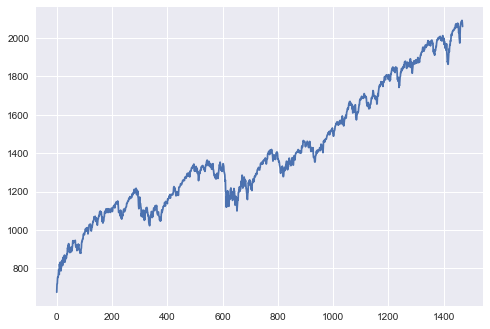

In [24]:
data = pd.read_csv("./SPX500.TXT", names = ["date", "open","high", "low", "close"], delimiter=" ", index_col =False)
close_p = data["close"].values

start = close_p.tolist().index(np.min(close_p))
data = close_p[start:]
data

mpl.style.use("seaborn")
plt.plot(data)
print("The data contains {} seqential observations.".format(data.shape[0]))

# 1.2 Define the geometric brownian motion

**Parameter:**
$r_t$: stock prices at time t

By definition, the process defined by $dS_t = \mu S_t dt + \sqrt{v_t}S_td\tilde W_t$ is a geometric brownian motion. The property is: $S(t+\Delta t) - S(t) \sim N(\mu, \Delta t v_t)$. 

We first do frequensist inference for the constant drift $\mu$. To do this, we add up all the segment differences $\sum_n^{1469-1}\Delta r_{t_n} = \sum_n^{1468}(r_{t_n}-r_{t_{n+1}})$. ( The reason why it is 1469 is that we have 1469 data points, therefore we have 1468 segments):

\begin{aligned}
S(t+\Delta t) - S(t) &\sim N(\mu, \Delta t v_t) \\
\frac{1}{1468}\sum_n^{1468}\Delta r_{t_n} &\sim N(\mu, \frac{\Delta t \sum_n v_{t_n}}{1468}) 
\end{aligned}

Therefore, from frequensist view, that $\frac{1}{1468}\sum_n^{1468}\Delta r_{t_n}$ is an unbiased and efficient estimator for $\mu$. We might be aware of the fact that this distribution has parameter $\Delta t$. How big a difference exactly is this difference in time? It doesn't matter in this modeling process (in fact it is a trading day) as the volatility $v_t$ can be adaptively scaled up or down to fit the curve. Therefore, it suffice to regard $\Delta t = 1$, leading to:

\begin{aligned}
\frac{1}{1468}\sum_n^{1468}\Delta r_{t_n} &\sim N(\mu, \frac{\sum_n v_{t_n}}{1468}) 
\end{aligned}

In [5]:
# Inferencing the value of mu
avg_mu = 0

length = data.shape[0]
for i in range(length-1):
    avg_mu += data[i+1] - data[i]
avg_mu /= (data.shape[0]-1)

print("average increase in stock price is : {}".format(avg_mu))

average increase in stock price is : 0.9416689373297004


## 1.3 Constructing required dataset

We're making the data input and the fitting target. 


First, we transform stock price data into matrix. Notice that as we're feeding in vector, we can feed in consecutive days (e.g. 5 days) as one sample. This will manually bring longer past memory into the Echo State Network and therefore better deal with long-term memory fitting.

Second, as the target output is a the return at the next time step, which follows the distribution $r_{t+1} \sim N(r_t+\mu, v_{t+1})$, where $v_{t+1}$ is the parameter we're interested in, the key is to maximize the log likelihood of $r_{t+1}$ by nicely predicting $v_{t+1}$:

\begin{aligned}
    \ell(r_{t+1}; r_{t}, \mu, v_{t+1}) &= \log(\frac{1}{\sqrt{2\pi v_{t+1}}}\mathrm{ Exp}\{-\frac{(r_{t+1}-r_{t}-\mu)^2}{2v_{t+1}}\})\\
    &= -\frac{1}{2}\log{(2\pi v_{t+1})}-\frac{(r_{t+1}-r_{t}-\mu)^2}{2v_{t+1}}\\
    &= -\frac{1}{2}\log{(2\pi)}-\frac{1}{2}\log{v_{t+1}}-\frac{(r_{t+1}-r_{t}-\mu)^2}{2v_{t+1}}
\end{aligned}

It is easy to picture that there the function $f(v_{t+1}) = \ell(r_{t+1}; r_{t}, \mu, v_{t+1})$ is a convex function. Therefore, to get the global maximum, we merely need to use calculate derivative to get local maxima (\bf NOTE: the minima doesn't exist as the pdf can be arbiturarily flat so that the likelihood will go to 0) :

\begin{aligned}
    \frac{d\ell(r_{t+1}; r_{t}, \mu, v_{t+1})}{dv_{t+1}} &= -\frac{1}{2v_{t+1}} + \frac{(r_{t+1}-r_{t}-\mu)^2}{2v_{t+1}^2} = 0\\
    v_{t+1} &= (r_{t+1}-r_{t}-\mu)^2 \geq 0
\end{aligned}

The calculated value is the target output sequence

**NOTE: target should be 1 sample less than input, as for t=0, there is nothing to be predicted**

In [25]:
# Making input states
u_dim = 200
u_num = length + 1 - u_dim

u = []
for i in range(u_num):
    ui = []
    for j in range(u_dim):
        ui.append(data[i+j])
    ui = np.array(ui)
    u.append(ui)
u = np.array(u).reshape(u_num, u_dim)

# Making target states
r_t_1 = data[u_dim:]
r_t_0 = data[u_dim-1:-1]
target = np.reshape(np.power( (r_t_1 - r_t_0 - avg_mu), 2), [-1,1])

print("shape of input: (#samples, #dimensions): {}".format(u.shape))
print("shape of target: (#samples, #dimensions): {}".format(target.shape))

shape of input: (#samples, #dimensions): (1270, 200)
shape of target: (#samples, #dimensions): (1269, 1)


## 1.4 Plug in data and start the training

We need to normalize the input data to make it not too big that dominates the previous tanh state which ranges between -1 and 1. Below are all extra needed parameters needed for training the Echo State Network

### Parameters
**u_dim:** (above) dimension of input data (how many consecutive days)  
**u_num:** (above) length of input data (how many days of observations)  
**u_mag:** scale of magnitude of entries of input data (np.max(u)=u_mag)  
**x_dim:** dimension of inner state  
**connectivity:** level of connectivity, range between $[0,1]$  
**spectral_radius:** spectral radius of $\mathbf{W}_{\text{r}}$   
**cutout:** number of observation at the end for prediction   
**forget:** number of observation at the begining not participating model training   
**cv_start:** the lower bound of alpha coefficient for ridge regression validation   
**cv_end:** the upper bound of alpha coefficient for ridge regression validation   
**cv_step:** the step of increment for alpha for ridge regression validation   
**val_cut:** the proportion between validation set and training set, $=\frac{\# \text{validation}}{\# \text{training}}$   
**verbose:** for debug mode, =True will return information of model parameters   

model ridge coefficient: 0.23000000000000007
Model training mse: 145480.25473943225
Model validation mse: 67240.59295958457
Model prediction mse: 115160.1351763692
Model prediction average error 339.35252345661024


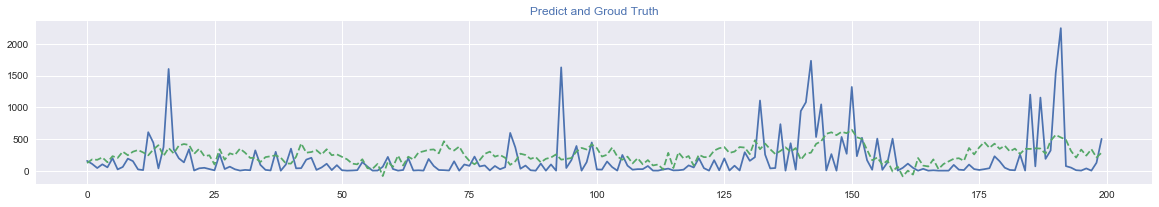

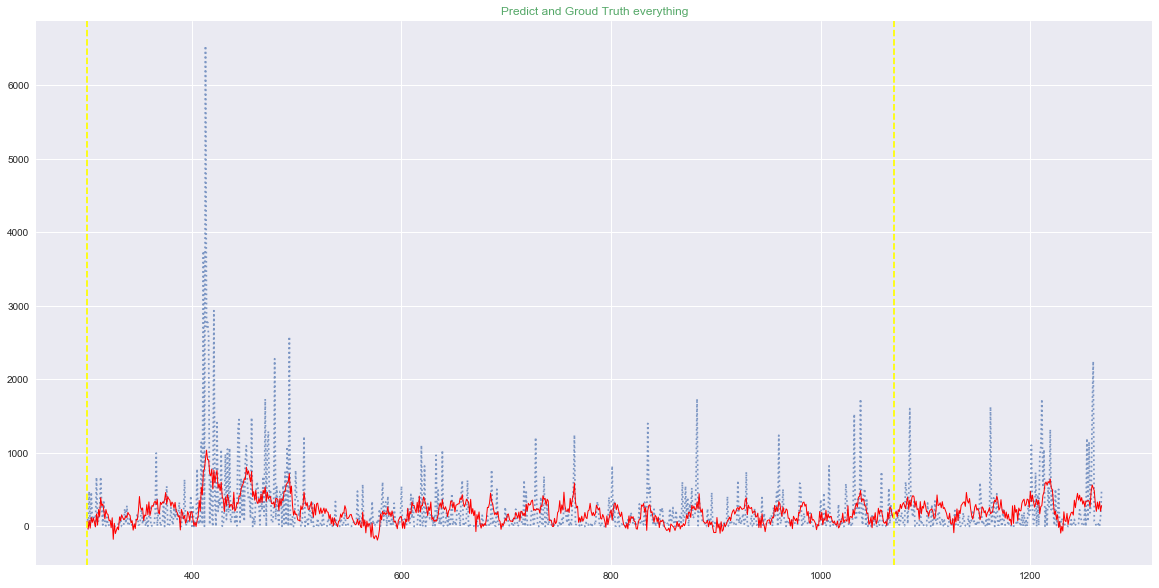

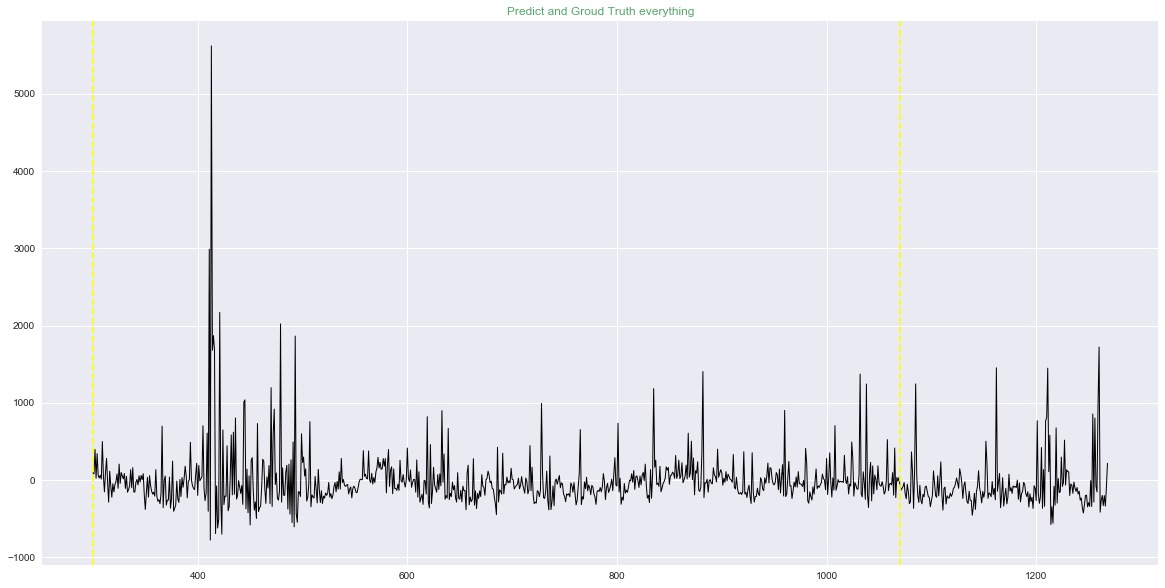

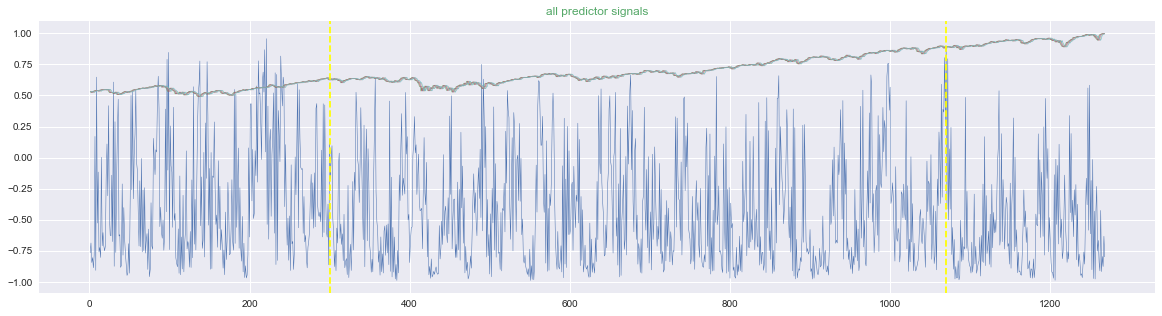

In [96]:
x_dim = 25
connectivity = 0.1
spectral_radius = 0.95

u_mag = 1


leak = 0.8 # the bigger the more focused on present

cutout = 200
forget = 300

cv_start = 0
cv_end = 1
cv_step = 0.01
val_cut = 0.2

verbose = False


u = u/np.max(u) * u_mag

EchoStateDeepTest(x_dim, connectivity, spectral_radius,
                u_num, u_dim, u_mag,
                  leak, cutout, forget, 
                  cv_start, cv_end, cv_step, val_cut, verbose, u, target, resvoir_num=2)

In [8]:
# -*- coding: utf-8 -*-
#
# File : examples/SwitchAttractor/switch_attractor_esn
# Description : Attractor switching task with ESN.
# Date : 26th of January, 2018
#
# This file is part of EchoTorch.  EchoTorch is free software: you can
# redistribute it and/or modify it under the terms of the GNU General Public
# License as published by the Free Software Foundation, version 2.
#
# This program is distributed in the hope that it will be useful, but WITHOUT
# ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
# FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more
# details.
#
# You should have received a copy of the GNU General Public License along with
# this program; if not, write to the Free Software Foundation, Inc., 51
# Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.
#
# Copyright Nils Schaetti <nils.schaetti@unine.ch>


# Imports
import torch
from echotorch.datasets.MackeyGlassDataset import MackeyGlassDataset
import echotorch.nn as etnn
import echotorch.utils
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader

# Dataset params
train_sample_length = 5000
test_sample_length = 1000
n_train_samples = 1
n_test_samples = 1
spectral_radius = 0.9
leaky_rate = 1.0
input_dim = 1
n_hidden = 100

# Use CUDA?
use_cuda = False
use_cuda = torch.cuda.is_available() if use_cuda else False

# Mackey glass dataset
mackey_glass_train_dataset = MackeyGlassDataset(train_sample_length, n_train_samples, tau=30)
mackey_glass_test_dataset = MackeyGlassDataset(test_sample_length, n_test_samples, tau=30)

print(mackey_glass_train_dataset)

# Data loader
trainloader = DataLoader(mackey_glass_train_dataset, batch_size=1, shuffle=False, num_workers=2)
testloader = DataLoader(mackey_glass_test_dataset, batch_size=1, shuffle=False, num_workers=2)

# ESN cell
esn = etnn.LiESN(
    input_dim=input_dim,
    hidden_dim=n_hidden,
    output_dim=1,
    spectral_radius=spectral_radius,
    learning_algo='inv',
    leaky_rate=leaky_rate
)
if use_cuda:
    esn.cuda()
# end if

# For each batch
for data in trainloader:
    # Inputs and outputs
    inputs, targets = data

    # To variable
    inputs, targets = Variable(inputs), Variable(targets)
    if use_cuda: inputs, targets = inputs.cuda(), targets.cuda()

    # Accumulate xTx and xTy
    esn(inputs, targets)
# end for

# Finalize training
esn.finalize()

# Train MSE
dataiter = iter(trainloader)
train_u, train_y = dataiter.next()
train_u, train_y = Variable(train_u), Variable(train_y)
if use_cuda: train_u, train_y = train_u.cuda(), train_y.cuda()
y_predicted = esn(train_u)
print(u"Train MSE: {}".format(echotorch.utils.mse(y_predicted.data, train_y.data)))
print(u"Test NRMSE: {}".format(echotorch.utils.nrmse(y_predicted.data, train_y.data)))
print(u"")

# Test MSE
dataiter = iter(testloader)
test_u, test_y = dataiter.next()
test_u, test_y = Variable(test_u), Variable(test_y)
if use_cuda: test_u, test_y = test_u.cuda(), test_y.cuda()
y_predicted = esn(test_u)
print(u"Test MSE: {}".format(echotorch.utils.mse(y_predicted.data, test_y.data)))
print(u"Test NRMSE: {}".format(echotorch.utils.nrmse(y_predicted.data, test_y.data)))
print(u"")


KeyboardInterrupt: 